# Install Libraries

In [1]:
!pip install pillow

# Download Dataset

In [2]:
DATASET_DIR = "scalene_triangle_0_355_step5"
!rm -rf "$DATASET_DIR"
!curl -L https://github.com/joshbarrass/Y4ProjectNotebooks/raw/master/scalene_triangle_0_355_step5.zip > "scalene_triangle_0_355_step5.zip"
!unzip -d "$DATASET_DIR" "scalene_triangle_0_355_step5.zip" > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   170  100   170    0     0   1096      0 --:--:-- --:--:-- --:--:--  1096
100  281k  100  281k    0     0   766k      0 --:--:-- --:--:-- --:--:--  766k


# Define Helper Functions

In [197]:
import tensorflow as tf
from tensorflow.keras import layers

D6_SHAPE = (3, 2)

def normalise(x):
    return x / np.linalg.norm(x)

def from_SO3_to_6D(SO3):
    """Convert an SO(3) rotation matrix to a 6D internal representation."""
    return SO3[:,:2]

def from_6D_to_SO3(D6):
    """Convert a 6D internal representation to an SO(3) rotation matrix."""
    b1 = normalise(D6[:,0])
    b2 = normalise(D6[:,1] - np.dot(b1, D6[:,1])*b1)
    b3 = np.cross(b1, b2)
    return np.array([b1, b2, b3]).T

def tf_6D_to_SO3(D6):
  """tensorflow-compatible conversion from 6D to SO(3). Used in the D6Convert layer."""
  a1 = D6[:,:,0]
  a2 = D6[:,:,1]
  b1 = tf.math.l2_normalize(a1, axis=-1)
  b2 = tf.math.l2_normalize(a2 - tf.reduce_sum(b1*a2)*b1, axis=-1)
  b3 = tf.linalg.cross(b1, b2)
  return tf.stack([b1, b2, b3], axis=2)

class D6Convert(layers.Layer):
  def call(self, inputs):
    target_input_shape = tf.TensorShape(((None,) + D6_SHAPE))
    if not inputs.shape.is_compatible_with(target_input_shape):
      raise TypeError("inputs to D6Convert should have shape {}, not {}".format(target_input_shape, inputs.shape))
    return tf_6D_to_SO3(inputs)

def SO3_distance(M1, M2):
  """Returns the distance between two SO3 matrices in degrees"""
  R = M1 * M2.T
  return np.rad2deg(np.arccos((np.trace(R)-1)/2))

In [193]:
from scipy.spatial.transform import Rotation as R
SO31 = R.from_euler("zyx",[3, 2, 1])
D61 = from_SO3_to_6D(SO31.as_matrix())
SO32 = R.from_euler("zyx",[0.5, 1, 1.2])
D62 = from_SO3_to_6D(SO32.as_matrix())
print("True:", SO3, sep="")
print("np1:", from_6D_to_SO3(D61))
print("np2:", from_6D_to_SO3(D62))
print("tf:", tf_6D_to_SO3(np.array([D61, D62])))

True:<scipy.spatial.transform.rotation.Rotation object at 0x7ff86f9fa4d0>
np1: [[ 0.41198225  0.05872664  0.90929743]
 [-0.68124272 -0.64287284  0.35017549]
 [ 0.60512725 -0.76371834 -0.2248451 ]]
np2: [[ 0.47415988 -0.25903472  0.84147098]
 [ 0.86199739 -0.05800686 -0.50358287]
 [ 0.17925654  0.96412459  0.19578273]]
tf: tf.Tensor(
[[[ 0.41198225  0.05872664  0.90929743]
  [-0.68124272 -0.64287284  0.35017549]
  [ 0.60512725 -0.76371834 -0.2248451 ]]

 [[ 0.47415988 -0.25903472  0.84147098]
  [ 0.86199739 -0.05800686 -0.50358287]
  [ 0.17925654  0.96412459  0.19578273]]], shape=(2, 3, 3), dtype=float64)


# Load and Pre-Process Training Data

Dataset contains 72 images
Image shape is (50, 50, 1)
x will have shape (72, 50, 50, 1)
y will have shape (72, 3, 3)
Processing image files...


  0%|          | 0/72 [00:00<?, ?it/s]

Selecting test data...


  0%|          | 0/14 [00:00<?, ?it/s]

x_data has shape (58, 50, 50, 1)
y_data has shape (58, 3, 3)
x_test has shape (14, 50, 50, 1)
y_test has shape (14, 3, 3)
x_data values range from 0.0 to 0.8509804010391235
[[-0.70710677  0.70710677  0.        ]
 [-0.70710677 -0.70710677  0.        ]
 [ 0.          0.          1.        ]]


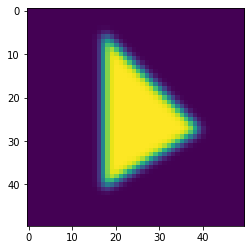

In [152]:
import os
import random
import numpy as np
from scipy.spatial.transform import Rotation as R
from PIL import Image, ImageFilter
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

random.seed(0)

RESIZE_SHAPE = (50, 50)

GAUSS_RADIUS = 1
image_filter = ImageFilter.GaussianBlur(radius=GAUSS_RADIUS)

image_files = os.listdir(DATASET_DIR)
total_images = len(image_files)
print(f"Dataset contains {total_images} images")
if total_images == 0:
  raise ValueError("dataset has no images")

# image_shape = Image.open(os.path.join(DATASET_DIR, image_files[0])).size
image_shape = RESIZE_SHAPE + (1,)
print(f"Image shape is {image_shape}")
x_data = np.zeros((total_images,) + image_shape, dtype="float32")
y_data = np.zeros((total_images, 3, 3), dtype="float32")
print(f"x will have shape {x_data.shape}")
print(f"y will have shape {y_data.shape}")
print("Processing image files...")
for i, imf in tqdm(enumerate(image_files), total=total_images):
  im = Image.open(os.path.join(DATASET_DIR, imf)).convert("L")
  im = im.resize(RESIZE_SHAPE)
  im = im.filter(image_filter)
  x_data[i,:,:] = np.array(im).reshape(image_shape)/255
  angle = float(os.path.splitext(imf)[0])
  y_data[i,:,:] = R.from_euler("zyx", (angle, 0, 0), True).as_matrix()

# take 20% of the images as test data
total_test_images = int(0.2*total_images)
x_test = np.zeros((total_test_images,) + x_data.shape[1:])
y_test = np.zeros((total_test_images,) + y_data.shape[1:])
print("Selecting test data...")
for i in tqdm(range(total_test_images)):
  r = random.randrange(x_data.shape[0])
  x_test[i] = x_data[r]
  x_data = np.delete(x_data, r, 0)
  y_test[i] = y_data[r]
  y_data = np.delete(y_data, r, 0)
print(f"x_data has shape {x_data.shape}")
print(f"y_data has shape {y_data.shape}")
print(f"x_test has shape {x_test.shape}")
print(f"y_test has shape {y_test.shape}")

print(f"x_data values range from {np.min(x_data)} to {np.max(x_data)}")

plt.imshow(x_data[0,:,:].reshape(RESIZE_SHAPE))
print(y_data[0,:,:])

# Construct Network

In [168]:
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 5
epochs = 200

model = keras.Sequential([
                          layers.InputLayer(input_shape=image_shape),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Flatten(),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(np.prod(D6_SHAPE), activation="tanh"),
                          layers.Reshape(D6_SHAPE),
                          D6Convert(),
])
model.summary()
model.compile(optimizer="sgd", loss="mean_squared_error", metrics=["accuracy"])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 3872)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 64)                247872    
_________________________________________________________________
dense_57 (Dense)             (None, 128)             

# Train Model

Epoch 1/200
12/12 [==============================] - 1s 17ms/step - loss: 0.4951 - accuracy: 0.5230
Epoch 2/200
12/12 [==============================] - 0s 17ms/step - loss: 0.4381 - accuracy: 0.6034
Epoch 3/200
12/12 [==============================] - 0s 16ms/step - loss: 0.4209 - accuracy: 0.5460
Epoch 4/200
12/12 [==============================] - 0s 17ms/step - loss: 0.4426 - accuracy: 0.5690
Epoch 5/200
12/12 [==============================] - 0s 19ms/step - loss: 0.4430 - accuracy: 0.5460
Epoch 6/200
12/12 [==============================] - 0s 18ms/step - loss: 0.4341 - accuracy: 0.5632
Epoch 7/200
12/12 [==============================] - 0s 19ms/step - loss: 0.4170 - accuracy: 0.5862
Epoch 8/200
12/12 [==============================] - 0s 17ms/step - loss: 0.4216 - accuracy: 0.5460
Epoch 9/200
12/12 [==============================] - 0s 18ms/step - loss: 0.4330 - accuracy: 0.5575
Epoch 10/200
12/12 [==============================] - 0s 17ms/step - loss: 0.4176 - accuracy: 0.5517

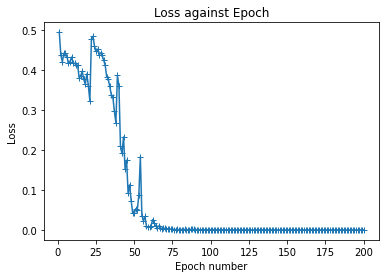

In [169]:
history = model.fit(
    x_data,
    y_data,
    batch_size,
    epochs,
)
plt.plot([i for i in range(1, len(history.history["loss"])+1)], history.history["loss"], "+-")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.title("Loss against Epoch")
plt.show()

# Test Model

In [170]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.006961010862141848
Test accuracy: 1.0


In [198]:
i = 1
print("True SO(3):\n", y_test[i].astype("float32"), end="\n\n", sep="")
prediction = model.predict(x_test[i].reshape((1,)+x_test[i].shape))[0]
print("SO(3) Prediction:\n", prediction, sep="")
print("Distance: {:.2f} degrees".format(SO3_distance(y_test[i], prediction)))

True SO(3):
[[-0.9961947   0.08715574  0.        ]
 [-0.08715574 -0.9961947   0.        ]
 [ 0.          0.          1.        ]]

SO(3) Prediction:
[[-0.99466246  0.10190786 -0.01616541]
 [-0.10205453 -0.9947423   0.00852181]
 [-0.01521198  0.01012608  0.999833  ]]
Distance: 7.76 degrees
